In [58]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from pathlib import Path
import pandas as pd
import sys
import pickle

# keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.layers.core import Lambda

ROOT_PATH = Path('/home/downloads/CarND-Behavioral-Cloning-P3/')
#ROOT_PATH=Path('/src')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

SAMPLE_DATA_PATH = ROOT_PATH/'data/sample_data'
print('tensorflow version: ', tf.__version__)
print('keras version: ', keras.__version__)
print('python version: ', sys.version_info)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4764598552817926049
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10919267533
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3801711344104377908
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:1e:00.0, compute capability: 6.1"
]
tensorflow version:  1.8.0
keras version:  2.2.0
python version:  sys.version_info(major=3, minor=5, micro=5, releaselevel='final', serial=0)


In [7]:
logs = pd.read_csv(SAMPLE_DATA_PATH/'driving_log.csv')

In [8]:
IMAGE_PATH = SAMPLE_DATA_PATH/'IMG'

In [25]:
def augment_img(img, y):
    img = np.fliplr(img)
    y = -y
    return img, y

In [77]:
'''
%%time
images = []
ys = []

correction = 0.2

for log in logs.iterrows():
    center, left, right, y = log[1][:4]
    for i, img_path in enumerate([center, left, right]):
        if i == 1:
            y_corrected = y + correction # left
        elif i == 2:
            y_corrected = y - correction # right
        else:
            y_corrected = y
        img = plt.imread(SAMPLE_DATA_PATH/img_path.strip())
        images.append(img)
        ys.append(y_corrected)
    
        # augmentation
        img_aug, y_aug = augment_img(img, y_corrected)
        images.append(img_aug)
        ys.append(y_aug)
    

x_train = np.array(images)
y_train = np.array(ys)

sample_data = {
    'x_train': x_train,
    'y_train': y_train
}

SAMPLE_DATA_SER_PATH = ROOT_PATH/'data/serialized_data/sample_data.pkl'

with open(str(SAMPLE_DATA_SER_PATH), 'wb') as f:
    pickle.dump(sample_data, f, protocol=4)
'''

"\n%%time\nimages = []\nys = []\n\ncorrection = 0.2\n\nfor log in logs.iterrows():\n    center, left, right, y = log[1][:4]\n    for i, img_path in enumerate([center, left, right]):\n        if i == 1:\n            y_corrected = y + correction # left\n        elif i == 2:\n            y_corrected = y - correction # right\n        else:\n            y_corrected = y\n        img = plt.imread(SAMPLE_DATA_PATH/img_path.strip())\n        images.append(img)\n        ys.append(y_corrected)\n    \n        # augmentation\n        img_aug, y_aug = augment_img(img, y_corrected)\n        images.append(img_aug)\n        ys.append(y_aug)\n    \n\nx_train = np.array(images)\ny_train = np.array(ys)\n\nsample_data = {\n    'x_train': x_train,\n    'y_train': y_train\n}\n\nSAMPLE_DATA_SER_PATH = ROOT_PATH/'data/serialized_data/sample_data.pkl'\n\nwith open(str(SAMPLE_DATA_SER_PATH), 'wb') as f:\n    pickle.dump(sample_data, f, protocol=4)\n"

In [76]:
%%time
with open(str(SAMPLE_DATA_SER_PATH), 'rb') as f:
    dd = pickle.load(f)

CPU times: user 675 ms, sys: 4.77 s, total: 5.45 s
Wall time: 6.11 s


In [78]:
print(x_train.shape, y_train.shape)

(48216, 160, 320, 3) (48216,)


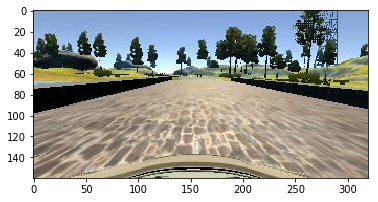

In [48]:
plt.imshow(x_train[0])

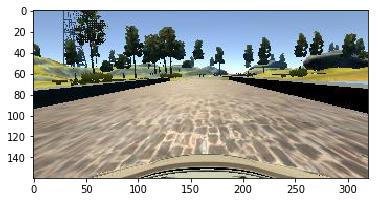

In [49]:
# image after augmentation
x0_aug, _ = augment_img(x_train[0], ys[0])
plt.imshow(x0_aug)

### Minimum Model

In [50]:
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Flatten(input_shape=(160, 320, 3)))
model.add(Dense(100))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [51]:
#model.fit(x_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3)

### LeNet

In [52]:
in_shape = (160, 320, 3)
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(in_shape)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=in_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 158, 318, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 79, 159, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 77, 157, 64)       18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 38, 78, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 38, 78, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 189696)            0         
__________

In [54]:
model.fit(x_train, y_train, validation_split=0.2, shuffle=True, epochs=3)

Train on 38572 samples, validate on 9644 samples
Epoch 1/3
38572/38572 [==============================] - 66s 2ms/step - loss: 0.2377 - val_loss: 0.0122
Epoch 2/3
38572/38572 [==============================] - 65s 2ms/step - loss: 0.0133 - val_loss: 0.0111
Epoch 3/3
38572/38572 [==============================] - 65s 2ms/step - loss: 0.0112 - val_loss: 0.0112


### Saving Model

In [55]:
model.save(ROOT_PATH/'models/model.h5', include_optimizer=False)